In [1]:
%matplotlib widget

In [2]:
import pyobjcryst
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
SAMPLE = 'cpd-1h.prn'

In [4]:
URL = f'https://www.iucr.org/__data/iucr/powder/QARR/col/{SAMPLE}'

In [6]:
os.system(f'curl {URL} -o {SAMPLE}')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  141k  100  141k    0     0   623k      0 --:--:-- --:--:-- --:--:--  623k


0

In [7]:
p = pyobjcryst.powderpattern.PowderPattern()

In [8]:
p.ImportPowderPattern2ThetaObs(SAMPLE)

Imported powder pattern: 7251 points, 2theta=  5.000 -> 150.000, step= 0.020


In [9]:
p.SetWavelength("Cu")

In [10]:
p.UpdateDisplay()

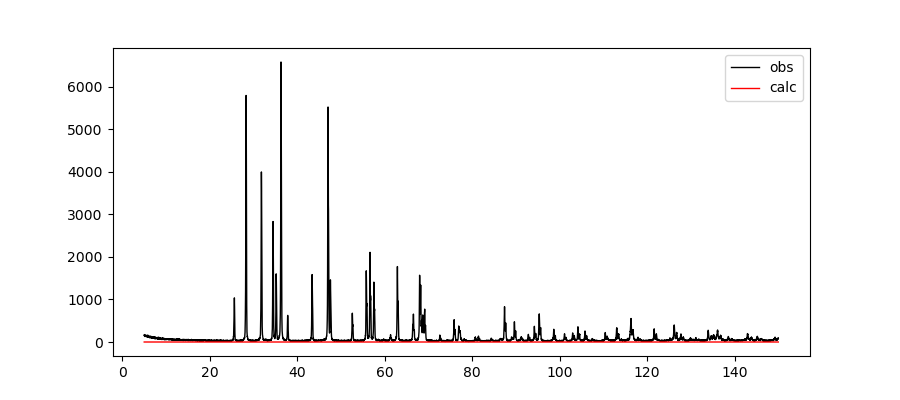

In [11]:
p.plot()

#### We think that there are three phases (molecules) in this diffractogram (each one registered in COD with an IDawait)

In [12]:
COD_IDS = [
    1000032,
    9008877,
    5000222,
]

In [13]:
COD_NAMES = [
    'Al2O3',
    'ZnO',
    'CaF2',
]

In [20]:
def get_crystal_dict(id, name):
    crystal_dict = {}
    crystal_dict['id'] = id
    crystal_dict['name'] = name
    crystal_dict['url'] = f'http://crystallography.net/cod/{id}.cif'
    crystal_dict['crystal'] = pyobjcryst.crystal.CreateCrystalFromCIF(file=crystal_dict['url'])
    os.system(f'curl {crystal_dict["url"]} -o {name}.cif')
    return crystal_dict

In [21]:
crystal_dicts = []
for id, name in zip(COD_IDS, COD_NAMES):
    crystal_dict = get_crystal_dict(id=id, name=name)
    crystal_dicts.append(crystal_dict)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3288  100  3288    0     0  33551      0 --:--:-- --:--:-- --:--:-- 33551
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2142  100  2142    0     0  22082      0 --:--:-- --:--:-- --:--:-- 22082
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4361  100  4361    0     0  45427      0 --:--:-- --:--:-- --:--:-- 45427


#### You have three instances of Crystal

In [16]:
crystal_dicts

[{'id': 1000032,
  'name': 'Al2O3',
  'url': 'http://crystallography.net/cod/1000032.cif',
  'crystal': <pyobjcryst.crystal.Crystal at 0x7f94064f91c0>},
 {'id': 9008877,
  'name': 'ZnO',
  'url': 'http://crystallography.net/cod/9008877.cif',
  'crystal': <pyobjcryst.crystal.Crystal at 0x7f9405991440>},
 {'id': 5000222,
  'name': 'CaF2',
  'url': 'http://crystallography.net/cod/5000222.cif',
  'crystal': <pyobjcryst.crystal.Crystal at 0x7f9405990220>}]

#### Add the Crystal instances to the PowderDiffraction instance

In [16]:
for crystal_d in crystal_dicts:
    p.AddPowderPatternDiffraction(crystal_d.get('crystal'))

In [17]:
p.get_crystalline_components()

In [18]:
p.FitScaleFactorForRw()

========================== WARNING =========================
   In ScatteringPowerAtom::GetTemperatureFactor():
   Anisotropic Displacement Parameters are not currently properly handled
   for Debye-Waller calculations (no symmetry handling for ADPs).
   =>The Debye-Waller calculations will instead use only isotropic DPs



In [19]:
p.UpdateDisplay()

In [20]:
p.GetNbPowderPatternComponent()

3

In [21]:
type(p.GetPowderPatternComponent(0))

pyobjcryst._pyobjcryst.PowderPatternDiffraction

In [22]:
x = p.GetPowderPatternX()

In [23]:
y = p.GetPowderPatternObs()

In [24]:
x.shape

(7251,)

##### Dont know what exactly is the x vector

In [25]:
bx = np.linspace(x.min(), x.max(), 30)
by = np.zeros(bx.shape)

#### Add background item (PowderPatternBackground)

In [26]:
b = p.AddPowderPatternBackground()

In [27]:
type(b)

pyobjcryst._pyobjcryst.PowderPatternBackground

In [28]:
b.SetInterpPoints(bx, by)

In [29]:
p.GetNbPowderPatternComponent()

4

In [30]:
b.UnFixAllPar()

In [31]:
b.OptimizeBayesianBackground()

In [32]:
p.UpdateDisplay()

#### Conservative fitting, pseudo-voigt with fixed width=0.00001

In [33]:
for ii in range(p.GetNbPowderPatternComponent()):
    component = p.GetPowderPatternComponent(ii)

    # Do not anything with Background Components
    if not isinstance(component, pyobjcryst.powderpattern.PowderPatternDiffraction):
        continue

    # Do with PowderPatternDiffraction
    component.SetReflectionProfilePar(pyobjcryst.powderpattern.ReflectionProfileType.PROFILE_PSEUDO_VOIGT, 0.00001)

#### Step 2

In [36]:
lsq = pyobjcryst.lsq.LSQ()

In [37]:
lsq.SetRefinedObj(p, 0, True, True)

In [38]:
lsq.PrepareRefParList(True)

In [39]:
lsqr = lsq.GetCompiledRefinedObj()

In [40]:
lsqr.FixAllPar()

In [41]:
lsq.SetParIsFixed(pyobjcryst.refinableobj.refpartype_scattdata_scale, False)

In [42]:
PARAMETERS = ['W', 'Zero', 'Eta0', 'a', 'b', 'c']

In [43]:
for par in PARAMETERS:
    for component in range(p.GetNbPowderPatternComponent()):

        lsq.SetParIsFixed(par + '~'*component, False)
lsq.SafeRefine(nbCycle=10, useLevenbergMarquardt=True, silent=True)

True

#### Final step

In [46]:
lsqr.FixAllPar()
# lsqr.Print()
# print(lsq.ChiSquare())
lsq.SetParIsFixed(pyobjcryst.refinableobj.refpartype_scattdata_scale, False)
for par in ["U", "V", "W", "Zero", "Eta0", "Eta1", "a", "b", "c", "2ThetaDispl", "2ThetaTransp"]:
    for i in range(p.GetNbPowderPatternComponent()):
        # This is a KLUDGE - we need this because parameter names are
        # unique, and thus "U" gets renamed to "U~", "U~~" in case of 2,3 phases.. 
        lsq.SetParIsFixed(par + "~"*i, False)
lsq.SafeRefine(nbCycle=10, useLevenbergMarquardt=True, silent=True)

p.FitScaleFactorForRw()

In [48]:
w = p.qpa(verbose=True)

Weight percentages:
Aluminium oxide - $-alpha:  37.42%
                  Zincite:  28.35%
         Calcium fluoride:  34.23%


In [55]:
x = '888883.3555555555'

In [56]:
x

'888883.3555555555'

In [61]:
f'{x:.2f}'

ValueError: Unknown format code 'f' for object of type 'str'

In [62]:
f'{x:.2f}'

ValueError: Unknown format code 'f' for object of type 'str'